# Imports and Setup

In [1]:
from huggingface_hub import login
login()

In [2]:
from datasets import load_dataset

# Loading Dataset

In [3]:
%%capture
dataset = load_dataset("semeru/code-text-java")

In [4]:
print("Available splits:", list(dataset.keys()))

Available splits: ['train', 'validation', 'test']


In [5]:
# Access the train split
train_dataset = dataset['train']

# Print column names
column_names = train_dataset.column_names
print("Column names:", column_names)

Column names: ['repo', 'path', 'func_name', 'original_string', 'language', 'code', 'code_tokens', 'docstring', 'docstring_tokens', 'sha', 'url', 'partition']


In [6]:
print("Columns in train dataset:", train_dataset.column_names)
print(f"Number of examples in train dataset: {len(train_dataset)}")

Columns in train dataset: ['repo', 'path', 'func_name', 'original_string', 'language', 'code', 'code_tokens', 'docstring', 'docstring_tokens', 'sha', 'url', 'partition', 'summary']
Number of examples in train dataset: 495953


In [6]:
# Create a filtered dataset with only the first 2000 examples
subset_size = 2000
dataset = train_dataset.select(range(subset_size))

In [7]:
print("Columns in filtered dataset:", dataset.column_names)
print(f"Number of examples in filtered dataset: {len(dataset)}")

Columns in filtered dataset: ['repo', 'path', 'func_name', 'original_string', 'language', 'code', 'code_tokens', 'docstring', 'docstring_tokens', 'sha', 'url', 'partition']
Number of examples in filtered dataset: 2000


In [8]:
dataset.push_to_hub("CarterPiepenburg/code-search-net-java-docgen")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/CarterPiepenburg/code-search-net-java-docgen/commit/f8b6cf442869ea60a06f23945bff2215b0659bf8', commit_message='Upload dataset', commit_description='', oid='f8b6cf442869ea60a06f23945bff2215b0659bf8', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/CarterPiepenburg/code-search-net-java-docgen', endpoint='https://huggingface.co', repo_type='dataset', repo_id='CarterPiepenburg/code-search-net-java-docgen'), pr_revision=None, pr_num=None)

# Converting dataset to ShareGPT

In [6]:
%%capture
from datasets import load_dataset   

dataset = load_dataset("CarterPiepenburg/code-search-net-java-docgen", split="train")

In [7]:
def to_sharegpt(dataset, merged_prompt, output_column_name, conversation_extension=1):
    """
    Convert dataset to ShareGPT format with proper variable substitution

    Args:
        dataset: The source dataset
        merged_prompt: Template string with {column_name} placeholders
        output_column_name: Column to use as the output/completion
        conversation_extension: Number of examples to combine into a single conversation
    """
    formatted_data = []

    for i in range(0, len(dataset), conversation_extension):
        conversation = []

        # Process each example in the current conversation window
        for j in range(i, min(i + conversation_extension, len(dataset))):
            example = dataset[j]

            # Format the prompt by substituting variables
            prompt = merged_prompt
            for column in dataset.column_names:
                if column in merged_prompt and column in example:
                    placeholder = "{" + column + "}"
                    prompt = prompt.replace(placeholder, str(example[column]))

            # Add the human message
            conversation.append({
                "from": "human",
                "value": prompt
            })

            # Add the assistant message
            conversation.append({
                "from": "assistant",
                "value": example[output_column_name]
            })

        # Add the conversation to the formatted data
        formatted_data.append({"conversations": conversation})

    return formatted_data

In [8]:
# For code explanation
code_explain_dataset = to_sharegpt(
    dataset,
    merged_prompt = "Explain what this Java code does: {code}",
    output_column_name = "docstring"
)

In [9]:
code_explain_dataset[0]

{'conversations': [{'from': 'human',
   'value': 'Explain what this Java code does: @Override\n    public ImageSource apply(ImageSource input) {\n        final int[][] pixelMatrix = new int[3][3];\n\n        int w = input.getWidth();\n        int h = input.getHeight();\n\n        int[][] output = new int[h][w];\n\n        for (int j = 1; j < h - 1; j++) {\n            for (int i = 1; i < w - 1; i++) {\n                pixelMatrix[0][0] = input.getR(i - 1, j - 1);\n                pixelMatrix[0][1] = input.getRGB(i - 1, j);\n                pixelMatrix[0][2] = input.getRGB(i - 1, j + 1);\n                pixelMatrix[1][0] = input.getRGB(i, j - 1);\n                pixelMatrix[1][2] = input.getRGB(i, j + 1);\n                pixelMatrix[2][0] = input.getRGB(i + 1, j - 1);\n                pixelMatrix[2][1] = input.getRGB(i + 1, j);\n                pixelMatrix[2][2] = input.getRGB(i + 1, j + 1);\n\n                int edge = (int) convolution(pixelMatrix);\n                int rgb = (edg

# Initialize Model and Token Register

In [10]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.


model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen2.5-1.5B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


C:\Users\carte\compsci\411\aiproject\new.venv\Lib\site-packages\unsloth_zoo\gradient_checkpointing.py:330: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  GPU_BUFFERS = tuple([torch.empty(2*256*2048, dtype = dtype, device = f"cuda:{i}") for i in range(n_gpus)])


==((====))==  Unsloth 2025.4.7: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 3060 Laptop GPU. Num GPUs = 1. Max memory: 6.0 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.7.0+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [11]:
from datasets import Dataset

# First, convert your list to a Hugging Face Dataset
code_explain_dataset_hf = Dataset.from_list(code_explain_dataset)

In [12]:
from unsloth import standardize_sharegpt
dataset = standardize_sharegpt(code_explain_dataset_hf)

Unsloth: Standardizing formats (num_proc=16):   0%|          | 0/2000 [00:00<?, ? examples/s]

In [13]:
from unsloth import apply_chat_template
chat_template = """
{SYSTEM}
USER: {INPUT}
ASSISTANT: {OUTPUT}"""

default_system_message = """You are generating brief documentation for a Java code snippet. "
    "Your response MUST be a single paragraph with NO bullet points, NO line breaks, and NO section headers. "
    "Do NOT explain the prompt. Just output the summary. "
    "Keep your explanation short and focused. Avoid repetition. "
    "Summarize ONLY the core logic and purpose of the code.\n\n"""

# Use this system message with the apply_chat_template function
dataset = apply_chat_template(
    dataset,
    tokenizer = tokenizer,
    chat_template = chat_template,
    default_system_message = default_system_message
)

Unsloth: We automatically added an EOS token to stop endless generations.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [14]:
dataset[2]

{'conversations': [{'content': 'Explain what this Java code does: protected void modify(Transaction t) {\n        try {\n            this.lock.writeLock().lock();\n            t.perform();\n        } finally {\n            this.lock.writeLock().unlock();\n        }\n    }',
   'role': 'user'},
  {'content': 'Executes the given transaction within the context of a write lock.\n\n@param t The transaction to execute.',
   'role': 'assistant'}],
 'text': 'You are generating brief documentation for a Java code snippet. "\n    "Your response MUST be a single paragraph with NO bullet points, NO line breaks, and NO section headers. "\n    "Do NOT explain the prompt. Just output the summary. "\n    "Keep your explanation short and focused. Avoid repetition. "\n    "Summarize ONLY the core logic and purpose of the code.\n\n\nUSER: Explain what this Java code does: protected void modify(Transaction t) {\n        try {\n            this.lock.writeLock().lock();\n            t.perform();\n        } 

# Training Model

In [15]:
split_dataset = dataset.train_test_split(test_size=0.3)
train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

In [16]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen2.5-1.5B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2025.4.7: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 3060 Laptop GPU. Num GPUs = 1. Max memory: 6.0 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.7.0+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [17]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
    "gate_proj", "up_proj", "down_proj" ,],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",
    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,
    # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.4.7 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [18]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 1,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        #warmup_steps = 5,
        warmup_steps = 10,
        #max_steps = 10,
        num_train_epochs = 1,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "ft-outputs",
        report_to = [],
    ),
)

Unsloth: Tokenizing ["text"]:   0%|          | 0/1400 [00:00<?, ? examples/s]

In [19]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,400 | Num Epochs = 1 | Total steps = 175
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 18,464,768/5,000,000,000 (0.37% trained)


Step,Training Loss


Step,Training Loss
1,2.407400
2,2.100100
3,2.111600
4,1.986200
5,2.213700
6,2.054300
7,2.014000
8,2.067200
9,1.947900
10,1.834400


TrainOutput(global_step=175, training_loss=0.9240056765079498, metrics={'train_runtime': 353.7761, 'train_samples_per_second': 3.957, 'train_steps_per_second': 0.495, 'total_flos': 3392184994295808.0, 'train_loss': 0.9240056765079498})

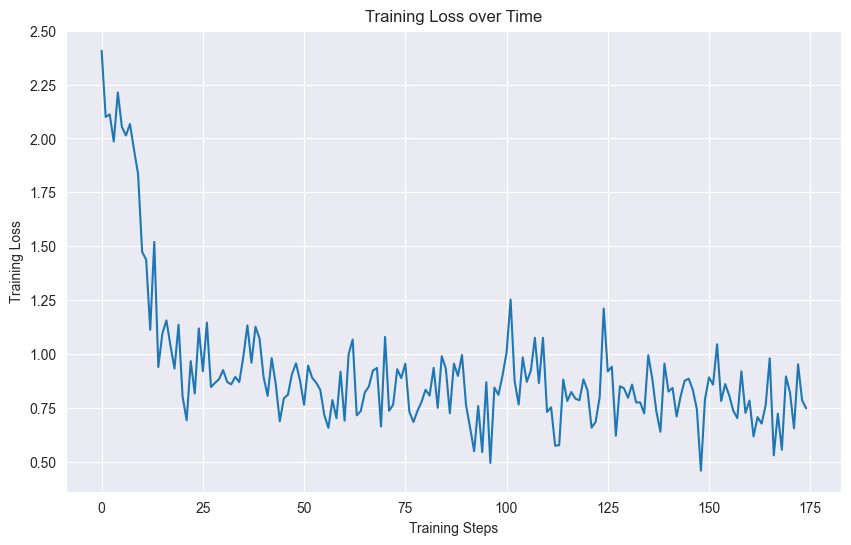

In [20]:
import matplotlib.pyplot as plt
import numpy as np
# After training is complete
training_logs = trainer.state.log_history
# Extract loss values
train_losses = [log.get('loss') for log in training_logs if 'loss' in log]
steps = list(range(len(train_losses)))
# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(steps, train_losses)
plt.xlabel('Training Steps')
plt.ylabel('Training Loss')
plt.title('Training Loss over Time')
plt.grid(True)
plt.show()

# Evaluation

In [78]:
import numpy as np
import json
import torch
from transformers import TextStreamer
from nltk.translate.bleu_score import sentence_bleu
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from safetensors import safe_open
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

In [79]:
from peft import PeftModel, PeftConfig
#Loading model and tokenizer from train checkpoint
model = AutoModelForCausalLM.from_pretrained("ft-outputs/checkpoint-175", device_map="cuda")
tokenizer = AutoTokenizer.from_pretrained("ft-outputs/checkpoint-175")

In [73]:
chat_template = """
{SYSTEM}
USER: {INPUT}
ASSISTANT: {OUTPUT}"""

# Setup system message consistent with your training
system_message = """You are generating brief documentation for a Java code snippet. "
    "Your response MUST be a single paragraph with NO bullet points, NO line breaks, and NO section headers. "
    "Do NOT explain the prompt. Just output the summary. "
    "Keep your explanation short and focused. Avoid repetition. "
    "Summarize ONLY the core logic and purpose of the code.\n\nSummary (one paragraph only):"""

In [74]:
# Function to run inference on a single example
def generate_explanation(code_to_explain):
    # Prepare user message with Java code for explanation
    user_message = f"Explain what this Java code does: {code_to_explain}"

    # Create the messages list with the system message and user message
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message}
    ]

    # Apply chat template to format the input consistently with how you trained
    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt",
        chat_template = chat_template,
        default_system_message = system_message
    ).to("cuda")

    # Generate response with appropriate parameters for code generation
    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            streamer=None,  # No streaming for batch processing
            max_new_tokens=256,
            pad_token_id=tokenizer.eos_token_id,
            temperature=0.2,
            top_p=0.9,
            repetition_penalty=1.1
        )

    # Decode the output, skipping the prompt
    generated_text = tokenizer.decode(outputs[0][input_ids.shape[1]:], skip_special_tokens=True)
    return generated_text

In [75]:
# Process examples from rows 700 to 1000
results = []
start_idx = 0
end_idx = 1000


# Convert to list if it's a Dataset object to ensure proper indexing
if hasattr(test_dataset, 'to_list'):
    dataset_list = test_dataset.to_list()
else:
    dataset_list = test_dataset

# Make sure we don't exceed the dataset length
end_idx = min(end_idx, len(dataset_list) - 1)
subset = dataset_list[start_idx:end_idx + 1]

print(f"Processing examples from index {start_idx} to {end_idx}")

# Create results directory if it doesn't exist
import os
os.makedirs("evaluation_results", exist_ok=True)

for i, example in enumerate(subset):
    # Extract the code from the user message
    if "conversations" in example:
        user_message = example["conversations"][0]["content"]
        # Extract just the code part (assuming it starts after "Explain what this Python code does: ")
        if "Explain what this Java code does: " in user_message:
            code_part = user_message.split("Explain what this Java code does: ")[1]
        else:
            code_part = user_message  # If no prefix, use the whole message

        # Generate explanation for this code
        explanation = generate_explanation(code_part)

        # Get the reference explanation
        reference_explanation = example["conversations"][1]["content"] if len(example["conversations"]) > 1 else ""

        # Store results
        results.append({
            "index": start_idx + i,
            "code": code_part,
            "reference_explanation": reference_explanation,
            "generated_explanation": explanation
        })

        # Print progress
        print(f"Processed example {start_idx + i} ({i + 1}/{len(subset)})")

        # Print the explanation
        print(f"Original code: {code_part[:100]}...")
        print(f"Generated explanation: {explanation}")
        print("-" * 50)

# Save raw results to a file
with open("evaluation_results/inference_results_1500_1510.json", "w") as f:
    json.dump(results, f, indent=2)

print(f"Raw results saved to evaluation_results/inference_results_1500_1510.json")

Processing examples from index 0 to 599


AttributeError: 'Qwen2Model' object has no attribute 'max_seq_length'